In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, test_df = data_loader.load_and_preprocess_data("1d", 0.5, 1)

Removed 25 outliers from 1002 observations. Percentage: 2.50%


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df_split['mood'].max() + 1

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=100)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-20 12:54:29,681] A new study created in memory with name: no-name-1eb9e3a5-e340-40b4-adb5-f7019d7aac38
[I 2025-04-20 12:54:35,396] Trial 0 finished with value: 0.3277358329833898 and parameters: {'hidden_dim': 98, 'id_embed_dim': 13, 'lr': 0.0010809975293592524, 'batch_size': 32, 'alpha': 0.20518236182378605}. Best is trial 0 with value: 0.3277358329833898.
[I 2025-04-20 12:54:35,737] Trial 1 finished with value: 0.44605851038954314 and parameters: {'hidden_dim': 82, 'id_embed_dim': 16, 'lr': 0.000319989716246688, 'batch_size': 64, 'alpha': 0.28535192919415925}. Best is trial 0 with value: 0.3277358329833898.
[I 2025-04-20 12:54:36,221] Trial 2 finished with value: 0.2617129311525732 and parameters: {'hidden_dim': 66, 'id_embed_dim': 10, 'lr': 0.0016430260580113595, 'batch_size': 32, 'alpha': 0.16835807415945803}. Best is trial 2 with value: 0.2617129311525732.
[I 2025-04-20 12:54:36,458] Trial 3 finished with value: 0.3167650840784374 and parameters: {'hidden_dim': 35, 'id_

Best hyperparams: {'hidden_dim': 100, 'id_embed_dim': 5, 'lr': 0.0016425234142092206, 'batch_size': 64, 'alpha': 0.01025857425935153}


In [6]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [7]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=25)

Epoch 1: train loss = 0.0994, val loss = 0.0787
Epoch 2: train loss = 0.0546, val loss = 0.0372
Epoch 3: train loss = 0.0237, val loss = 0.0193
Epoch 4: train loss = 0.0133, val loss = 0.0180
Epoch 5: train loss = 0.0107, val loss = 0.0169
Epoch 6: train loss = 0.0099, val loss = 0.0161
Epoch 7: train loss = 0.0095, val loss = 0.0154
Epoch 8: train loss = 0.0091, val loss = 0.0150
Epoch 9: train loss = 0.0090, val loss = 0.0153
Epoch 10: train loss = 0.0086, val loss = 0.0146
Epoch 11: train loss = 0.0083, val loss = 0.0147
Epoch 12: train loss = 0.0080, val loss = 0.0147
Epoch 13: train loss = 0.0079, val loss = 0.0139
Epoch 14: train loss = 0.0076, val loss = 0.0144
Epoch 15: train loss = 0.0073, val loss = 0.0142
Epoch 16: train loss = 0.0072, val loss = 0.0146
Epoch 17: train loss = 0.0070, val loss = 0.0140
Epoch 18: train loss = 0.0066, val loss = 0.0143
Epoch 19: train loss = 0.0065, val loss = 0.0145
Epoch 20: train loss = 0.0063, val loss = 0.0149
Epoch 21: train loss = 0.0062

MAPE: 9.88%, MAE: 0.68, MSE: 0.87, R_squared: -0.51


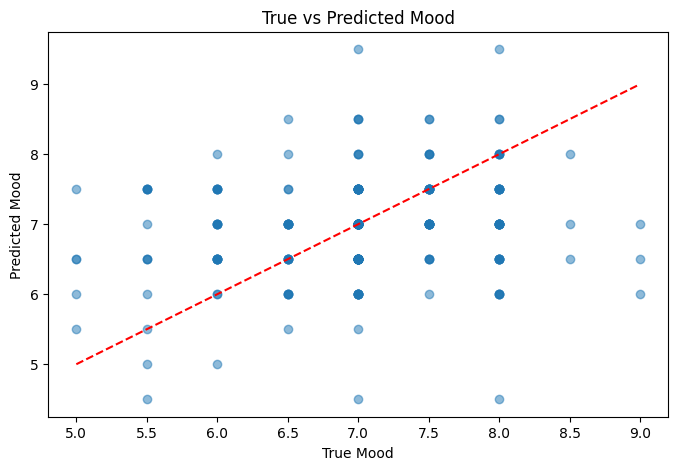

In [8]:
plot_mood_predictions(model, val_loader, device)

In [9]:
from mood_RNN_classifier import get_accuracy_rate
accuracy = get_accuracy_rate(model, val_loader, device)

Accuracy: 0.2632


In [10]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    13
1   AS14.02                    14
2   AS14.03                    16
3   AS14.05                    12
4   AS14.06                    13
5   AS14.07                     9
6   AS14.08                    13
7   AS14.09                    14
8   AS14.12                    14
9   AS14.13                    15
10  AS14.14                    14
11  AS14.15                    13
12  AS14.16                    13
13  AS14.17                    14
14  AS14.19                    13
15  AS14.20                    12
16  AS14.23                    12
17  AS14.24                    13
18  AS14.25                    13
19  AS14.26                    15
20  AS14.27                    15
21  AS14.28                    16
22  AS14.29                    15
23  AS14.30                    15
24  AS14.31                    13
25  AS14.32                    15
26  AS14.33                    13
